In [41]:
%matplotlib inline
# Retina
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import tracemalloc


In [2]:
class NaiveKNN:
    def __init__(self):
        self.data = None

    def fit(self, X):
        self.data = X

    def query(self, query_pt, k=1):
        distances = np.linalg.norm(self.data - query_pt, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return nearest_indices


In [ ]:
import time
import tracemalloc

def benchmark_knn(knn, X, query_pt, k):
    tracemalloc.start()
    start_time = time.perf_counter()
    knn.fit(X)
    fit_time = time.perf_counter() - start_time
    current_memory, fit_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tracemalloc.start() 
    start_time = time.perf_counter()
    knn.query(query_pt, k)
    query_time = time.perf_counter() - start_time
    current_memory, query_memory = tracemalloc.get_traced_memory() 
    tracemalloc.stop()

    return fit_time, query_time, fit_memory, query_memory


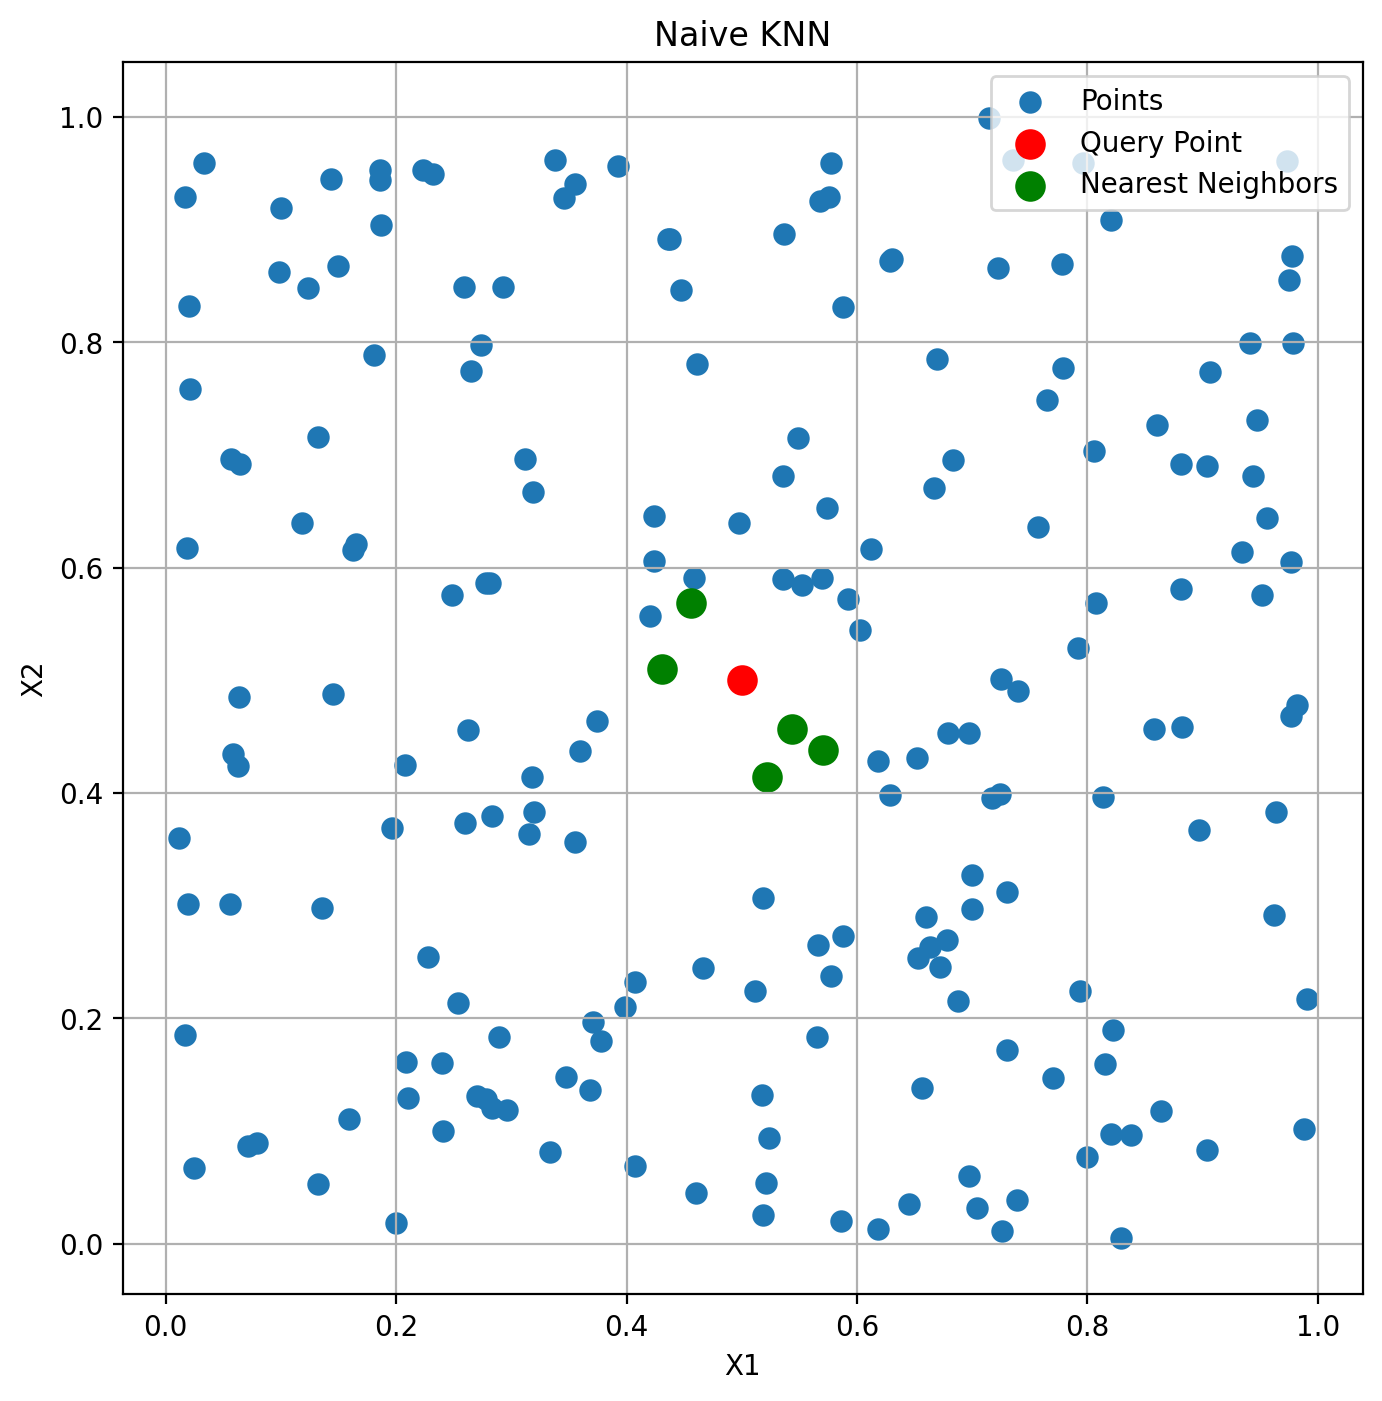

In [4]:
np.random.seed(0)
X_2d = np.random.rand(200, 2)
query_pt_2d = np.array([0.5, 0.5])


naive_2d = NaiveKNN()
naive_2d.fit(X_2d)
naive_indices = naive_2d.query(query_pt_2d, k=5)

plt.figure(figsize=(8, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], label="Points", s=50)
plt.scatter(query_pt_2d[0], query_pt_2d[1], color='red', label="Query Point", s=100)
plt.scatter(X_2d[naive_indices, 0], X_2d[naive_indices, 1], color='green', label="Nearest Neighbors", s=100)

plt.legend()
plt.title("Naive KNN")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()


In [5]:
class KDTree:
    def __init__(self, min_samples_split=8):
        self.min_samples_split = min_samples_split
        self.tree = None
        self.splits = []
        self.leafs= []

    def fit(self, X):
        self.tree = self._build_tree(X)


    def _build_tree(self, X, depth=0):
        if len(X) <= self.min_samples_split:
            self.leafs.append(X)
            return X

        dim = depth % X.shape[1]

        X = X[X[:, dim].argsort()]

        median_idx = len(X) // 2
        self.splits.append((X[median_idx, dim], dim))
        return {
            'dim': dim,
            'val': X[median_idx, dim],
            'left': self._build_tree(X[:median_idx], depth + 1),
            'right': self._build_tree(X[median_idx:], depth + 1)
        }

    def query_helper(self, node, query_pt, k):
        if isinstance(node, np.ndarray):
            return node

        dim = node['dim']
        val = node['val']

        if query_pt[dim] < val:
            return self.query_helper(node['left'], query_pt, k)
        else:
            return self.query_helper(node['right'], query_pt, k)
        
    def naive(self, arr : np.ndarray, query_pt, k):
        distances = np.linalg.norm(arr - query_pt, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return arr[nearest_indices]
    def query(self, query_pt, k=1):
        nparr = (self.query_helper(self.tree, query_pt, k))
        return self.naive(nparr, query_pt, k)
    

In [56]:
def plot_partitions_kdtree(node : dict, x_min, x_max, y_min, y_max):
    if isinstance(node, np.ndarray):
        return

    dim = node['dim']
    val = node['val']

    if dim == 0:
        plt.plot([val, val], [y_min, y_max], color='black')
        plot_partitions_kdtree(node['left'], x_min, val, y_min, y_max)
        plot_partitions_kdtree(node['right'], val, x_max, y_min, y_max)
    else:
        plt.plot([x_min, x_max], [val, val], color='black')
        plot_partitions_kdtree(node['left'], x_min, x_max, y_min, val)
        plot_partitions_kdtree(node['right'], x_min, x_max, val, y_max)

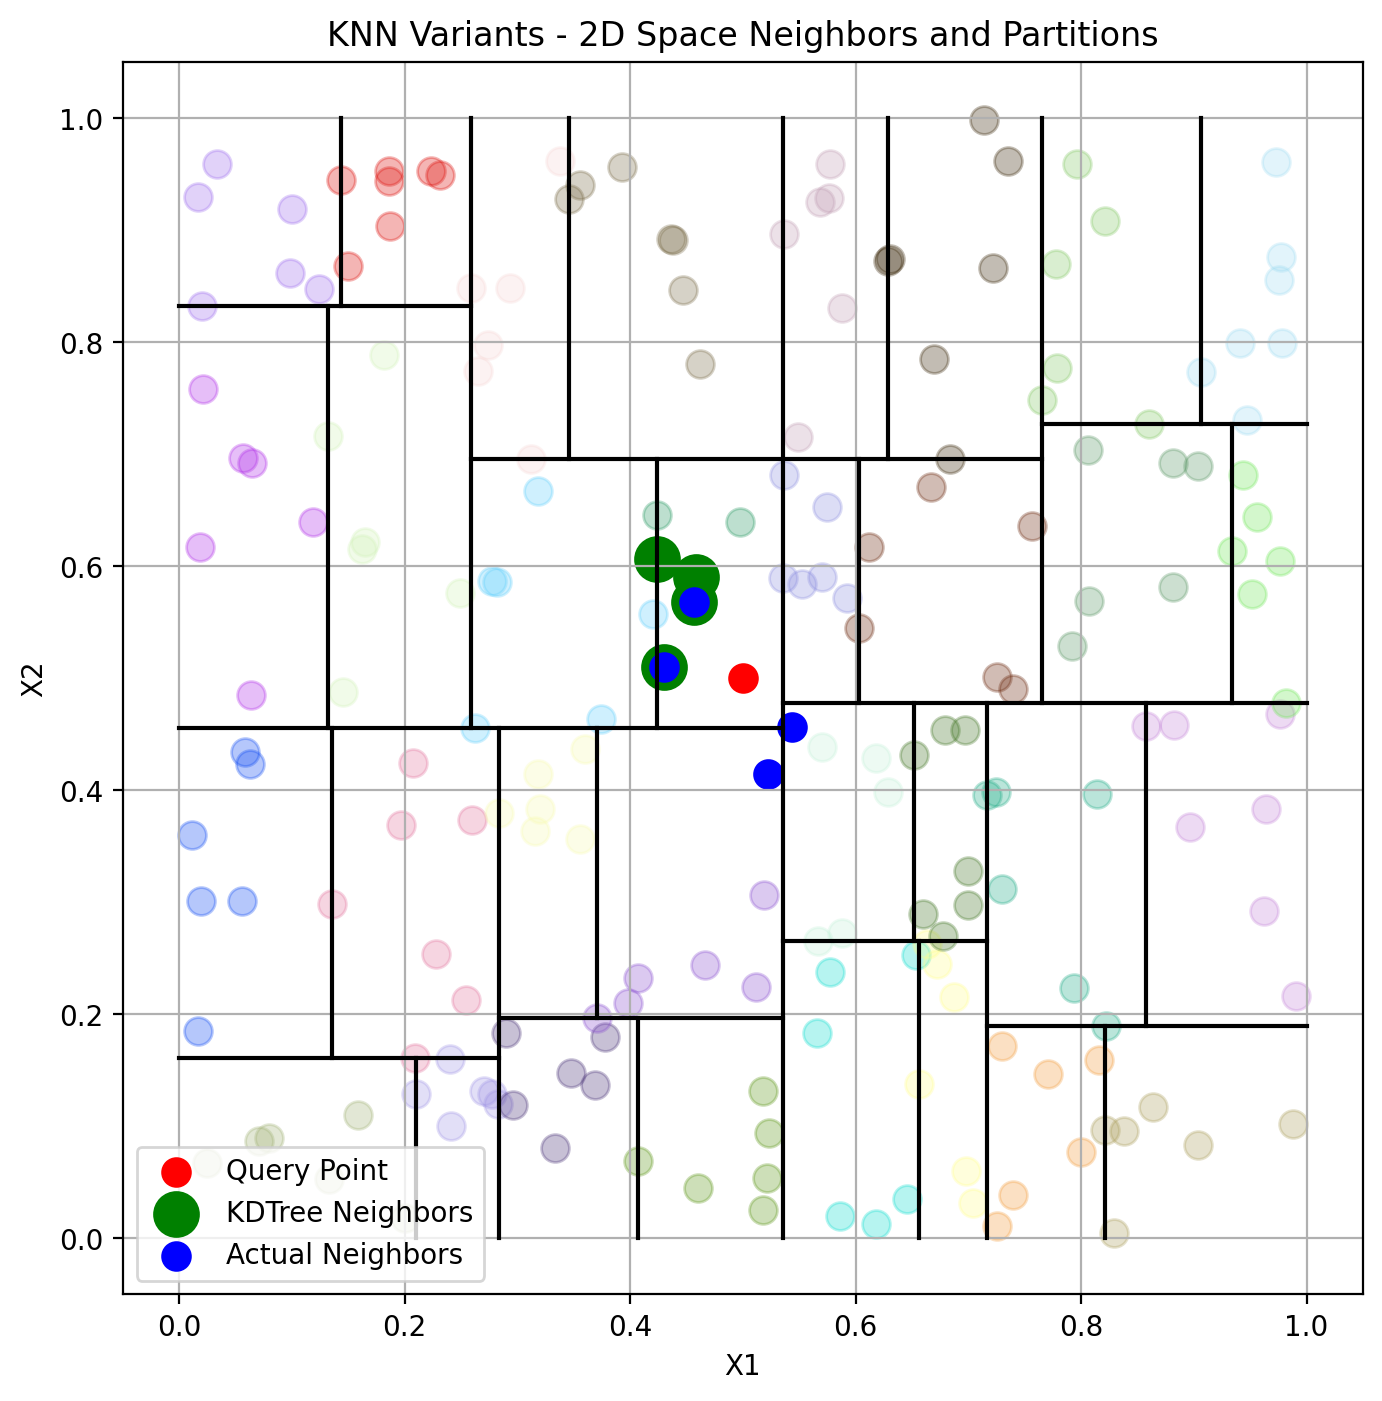

In [58]:
kdtree = KDTree()
kdtree.fit(X_2d)
kdtree_points = kdtree.query(query_pt_2d, k=4)

naive_2d_knnfalse = NaiveKNN()
naive_2d_knnfalse.fit(X_2d)
naive_indices = naive_2d.query(query_pt_2d, k=4)

plt.figure(figsize=(8, 8))

for i in kdtree.leafs:
    plt.scatter(i[:, 0], i[:, 1], color= np.random.rand(3,), s=100, alpha=0.3)

plt.scatter(query_pt_2d[0], query_pt_2d[1], color='red', label="Query Point", s=100)
plt.scatter(kdtree_points[:, 0], kdtree_points[:, 1], color='green', label="KDTree Neighbors", s= 250)
plt.scatter(X_2d[naive_indices, 0], X_2d[naive_indices, 1], color='blue', label="Actual Neighbors", s=100)

plt.legend()
plt.title("KDTree KNN")
plt.title("KNN Variants - 2D Space Neighbors and Partitions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plot_partitions_kdtree(kdtree.tree, 0, 1, 0, 1)
plt.show()


In [ ]:
class LSH:
    def __init__(self, n_projections=10, n_neighbors=5, radomn_seed = 42):
        self.random_seed = radomn_seed
        np.random.seed(radomn_seed)
        self.n_projections = n_projections
        self.n_neighbors = n_neighbors
        self.projections = None
        self.hash_table = {}

    def fit(self, X):
        np.random.seed(self.random_seed)
        self.projections = np.random.randn(X.shape[1] + 1, self.n_projections)
        X_aug = np.hstack([ np.ones((X.shape[0], 1)), X])
        X__ = X_aug @ self.projections
        X_str = np.array([''.join('1' if i > 0 else '0' for i in list(x)) for x in X__])
        for i, x in enumerate(X_str):
            if x not in self.hash_table:
                self.hash_table[x] = []
            self.hash_table[x].append(X_aug[i,1:])

        for x in self.hash_table:
            self.hash_table[x] = np.array(self.hash_table[x])

    
    def naive(self, arr : np.ndarray, query_pt, k):
        distances = np.linalg.norm(arr - query_pt, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return arr[nearest_indices]
    

    def query(self, query_pt, k=1):
        np.random.seed(self.random_seed)
        query_pt_ = np.hstack([1, query_pt])
        print(self.projections.shape, query_pt.shape)
        projs = query_pt_ @ self.projections
        hash__ = ''.join('1' if i > 0 else '0' for i in list(projs))
        if hash__ not in self.hash_table:
            return []
    
        return self.naive(self.hash_table[hash__], query_pt, k)

(3, 3) (2,)


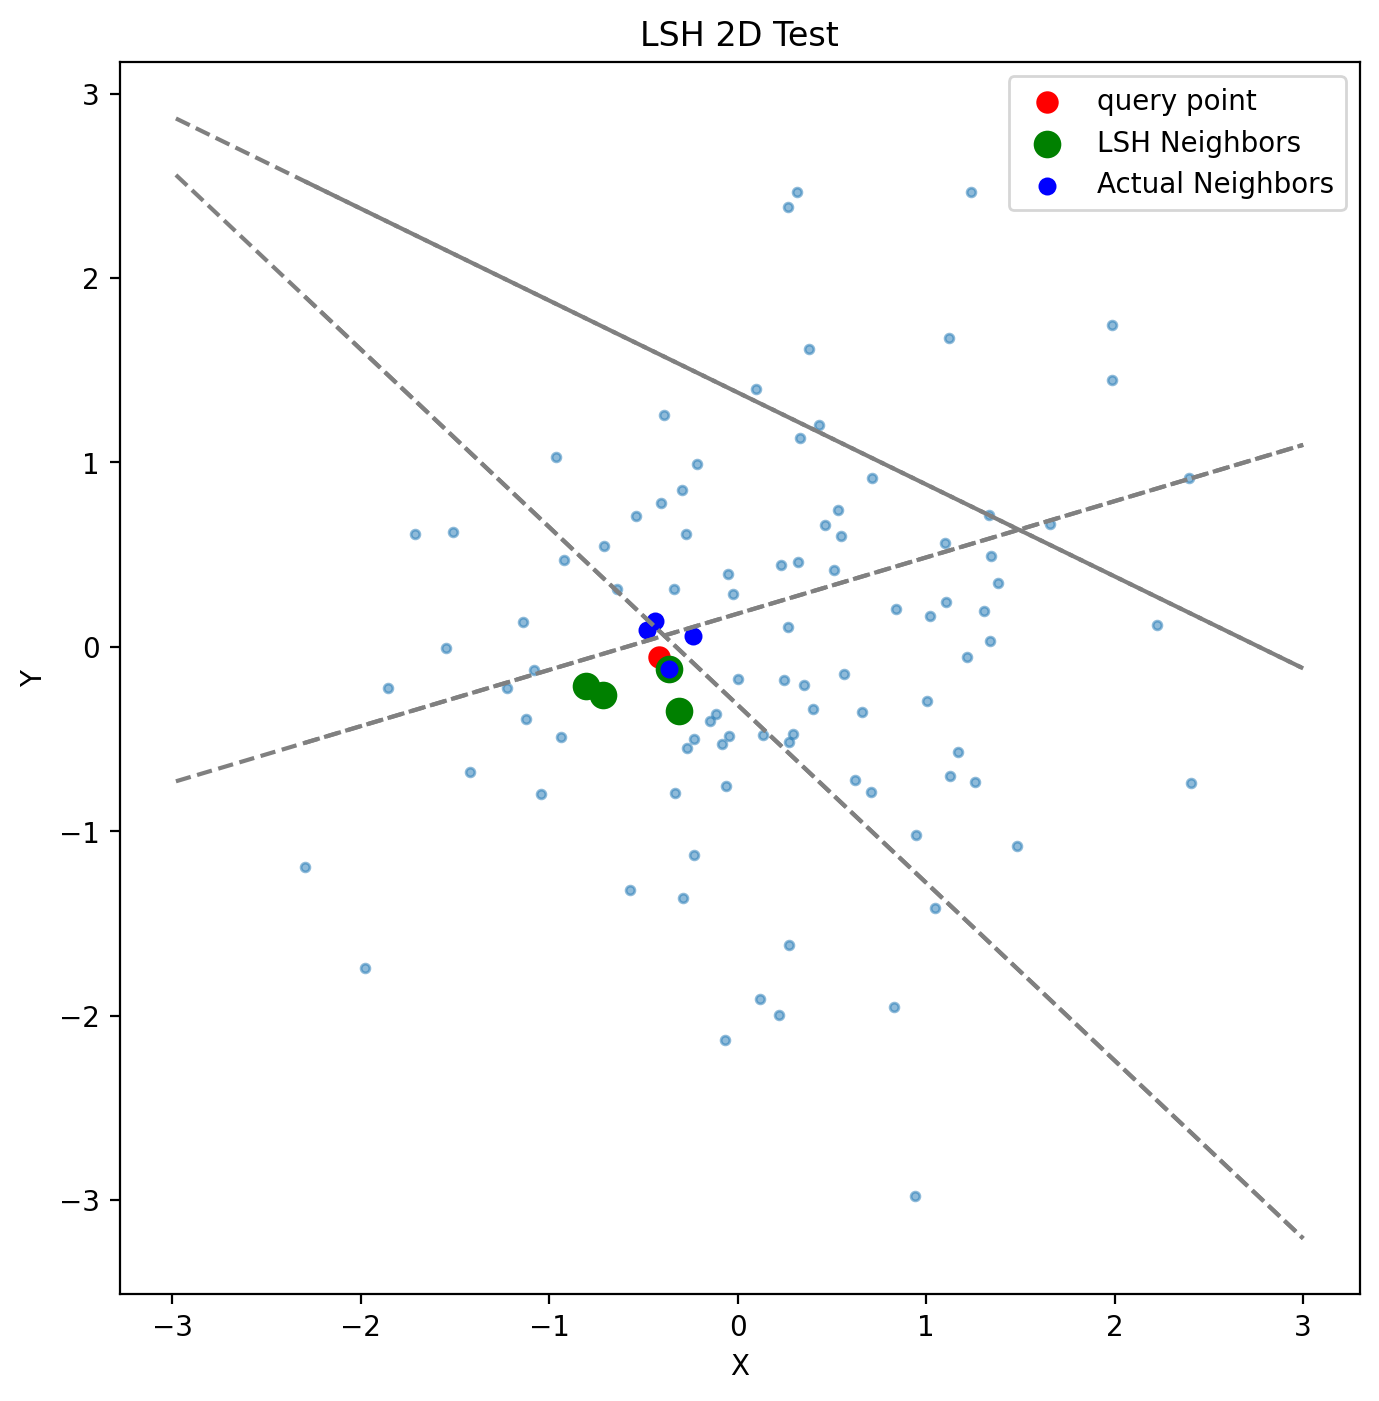

[[-0.36249918 -0.12190569]
 [-0.31282876 -0.34888192]
 [-0.71279944 -0.26085948]
 [-0.80459114 -0.21269764]]
[34 48 58 77]


In [60]:
np.random.seed(10)
n = 100
X = np.random.randn(n, 2)


np.random.seed(2)
query_pt = np.random.randn(2)

naive_2d_lshfalse = NaiveKNN()
naive_2d_lshfalse.fit(X)
naive_indices = naive_2d_lshfalse.query(query_pt, k=4)

lsh = LSH(n_projections=3, n_neighbors=2, radomn_seed=42)
lsh.fit(X)

neighbors = lsh.query(query_pt, k=4)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)
ax.scatter(query_pt[0], query_pt[1], s=50, c='r', marker='o', label = 'query point')
ax.scatter(neighbors[:,0], neighbors[:,1], s=80, c='g', marker='o', label='LSH Neighbors')
ax.scatter(X[naive_indices, 0], X[naive_indices, 1], color='blue', label="Actual Neighbors", s=30)
for i in range(lsh.n_projections):
    intercept = -lsh.projections[0, i]/lsh.projections[2, i]
    slope = -lsh.projections[1, i] / lsh.projections[2, i]
    x_values = np.linspace(np.min(X, axis = 0), 3, 100)
    plt.plot(x_values, slope * x_values + intercept, linestyle='--', color='gray')

ax.set_title('LSH 2D Test')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.legend()
plt.show()

print(neighbors)
print(naive_indices)

Varying $N$(dataset size) and $D$(number of dimensions) and testing

(3, 15) (2,)
(3, 15) (2,)
(3, 15) (2,)
(3, 15) (2,)
(3, 15) (2,)


<Figure size 1000x600 with 0 Axes>

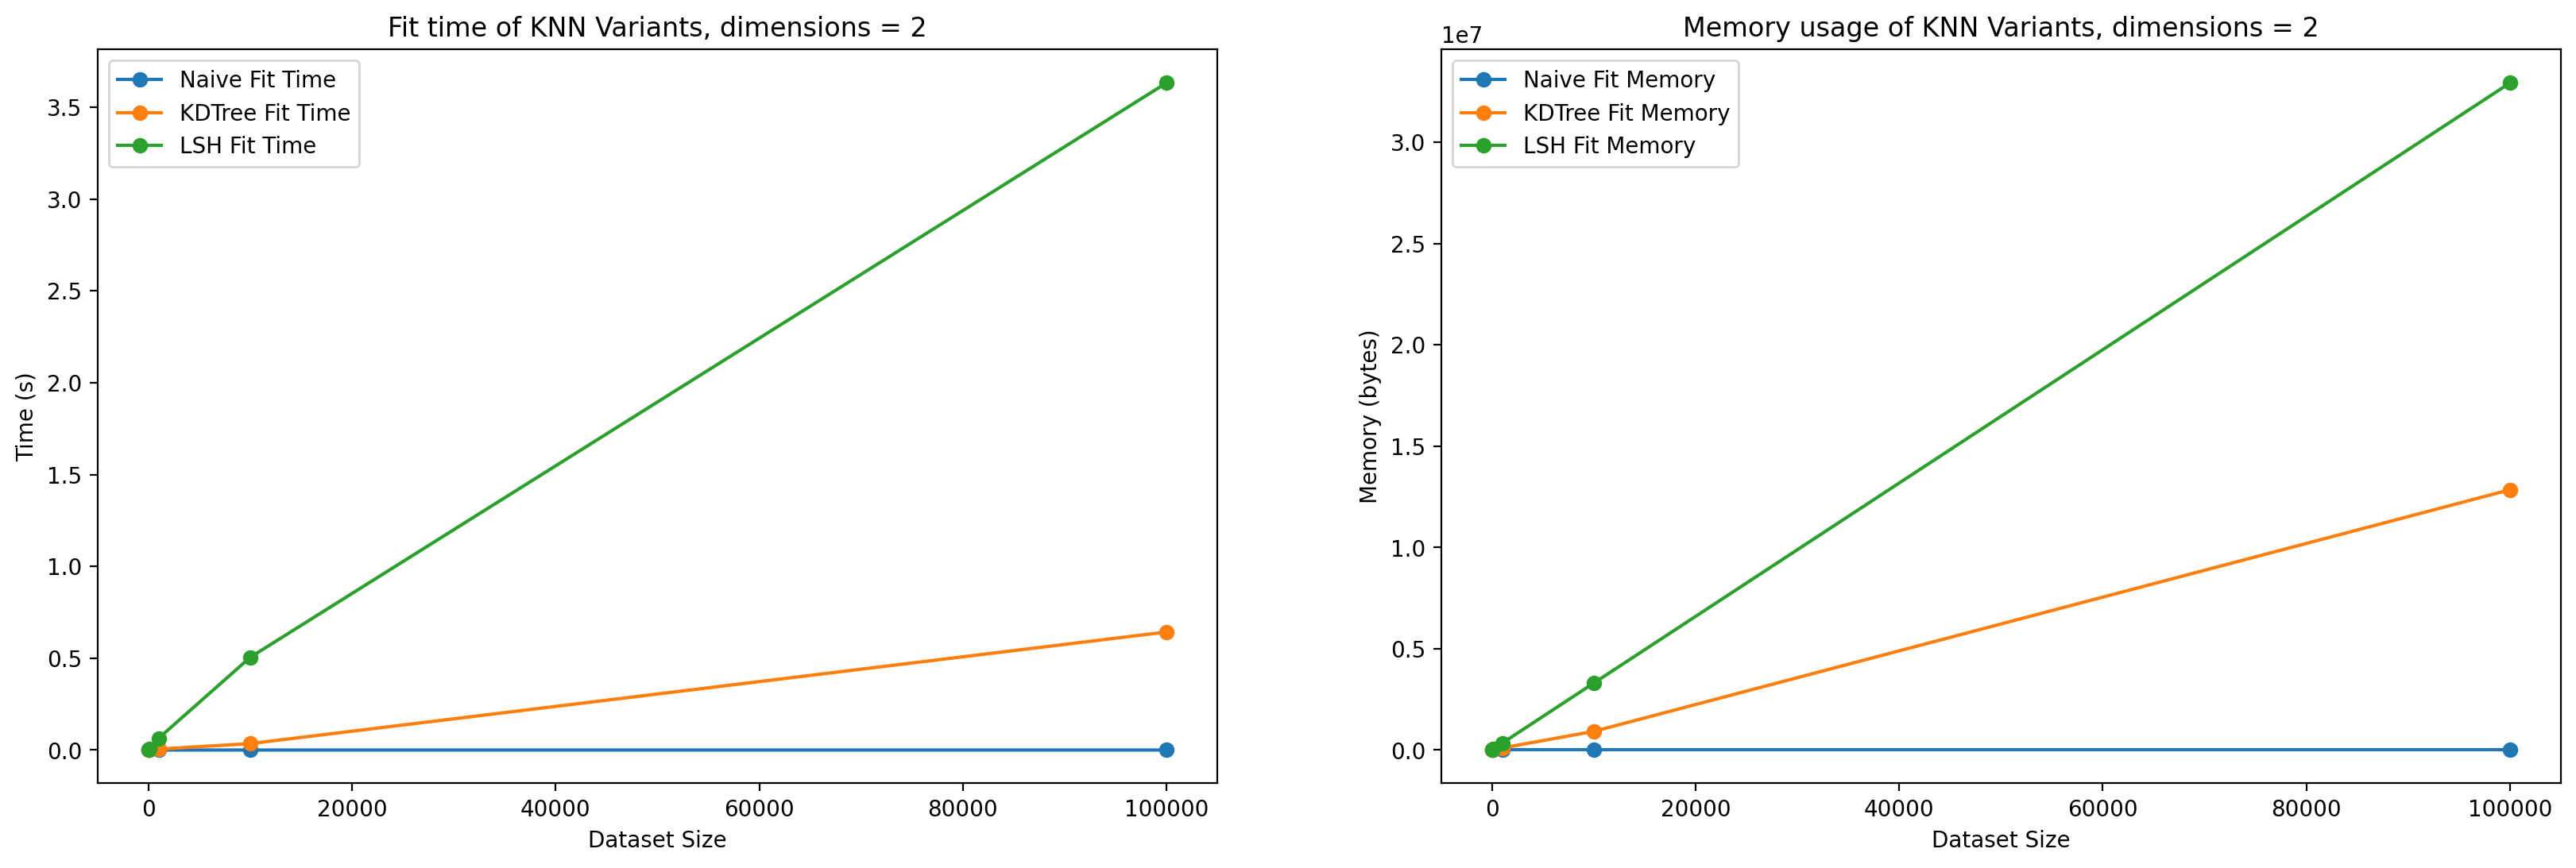

<Figure size 1000x600 with 0 Axes>

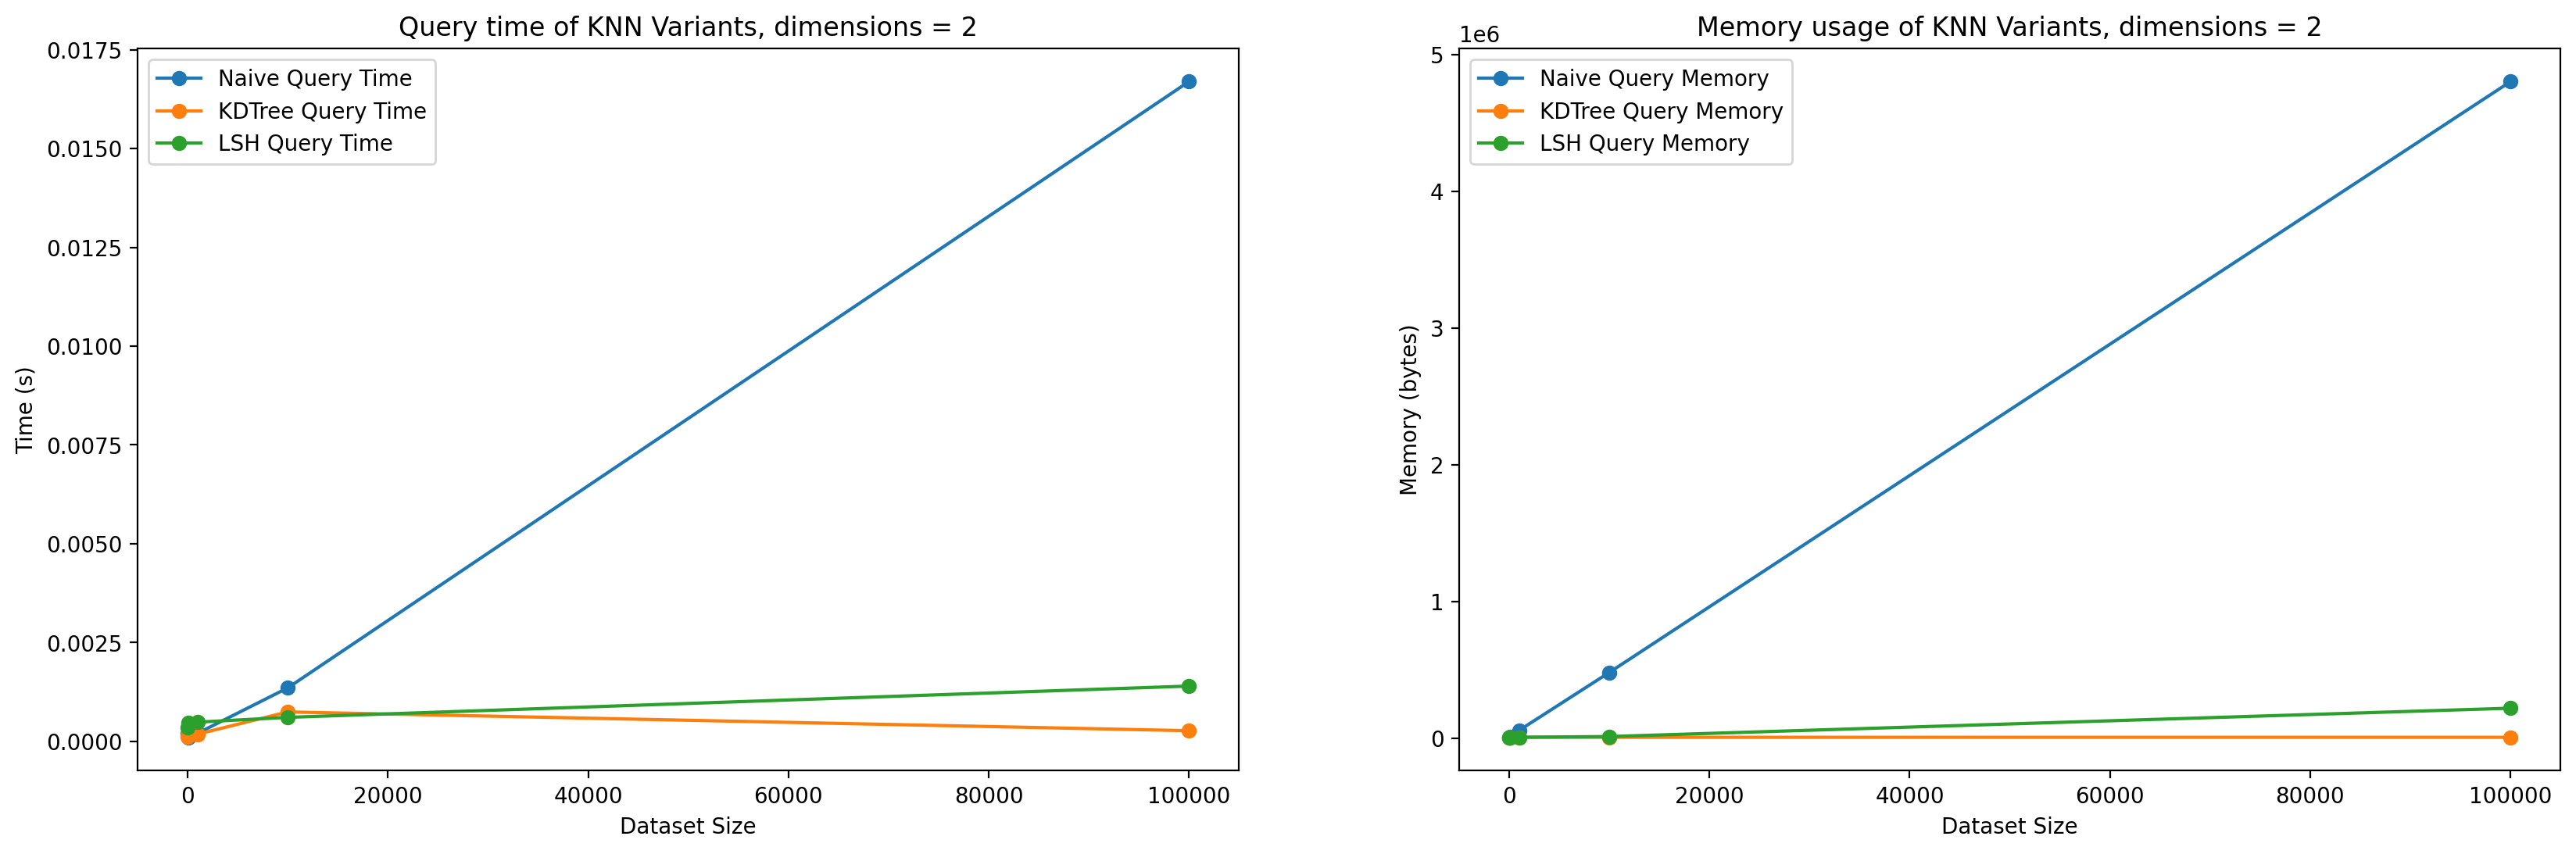

(11, 15) (10,)
(11, 15) (10,)
(11, 15) (10,)
(11, 15) (10,)
(11, 15) (10,)


<Figure size 1000x600 with 0 Axes>

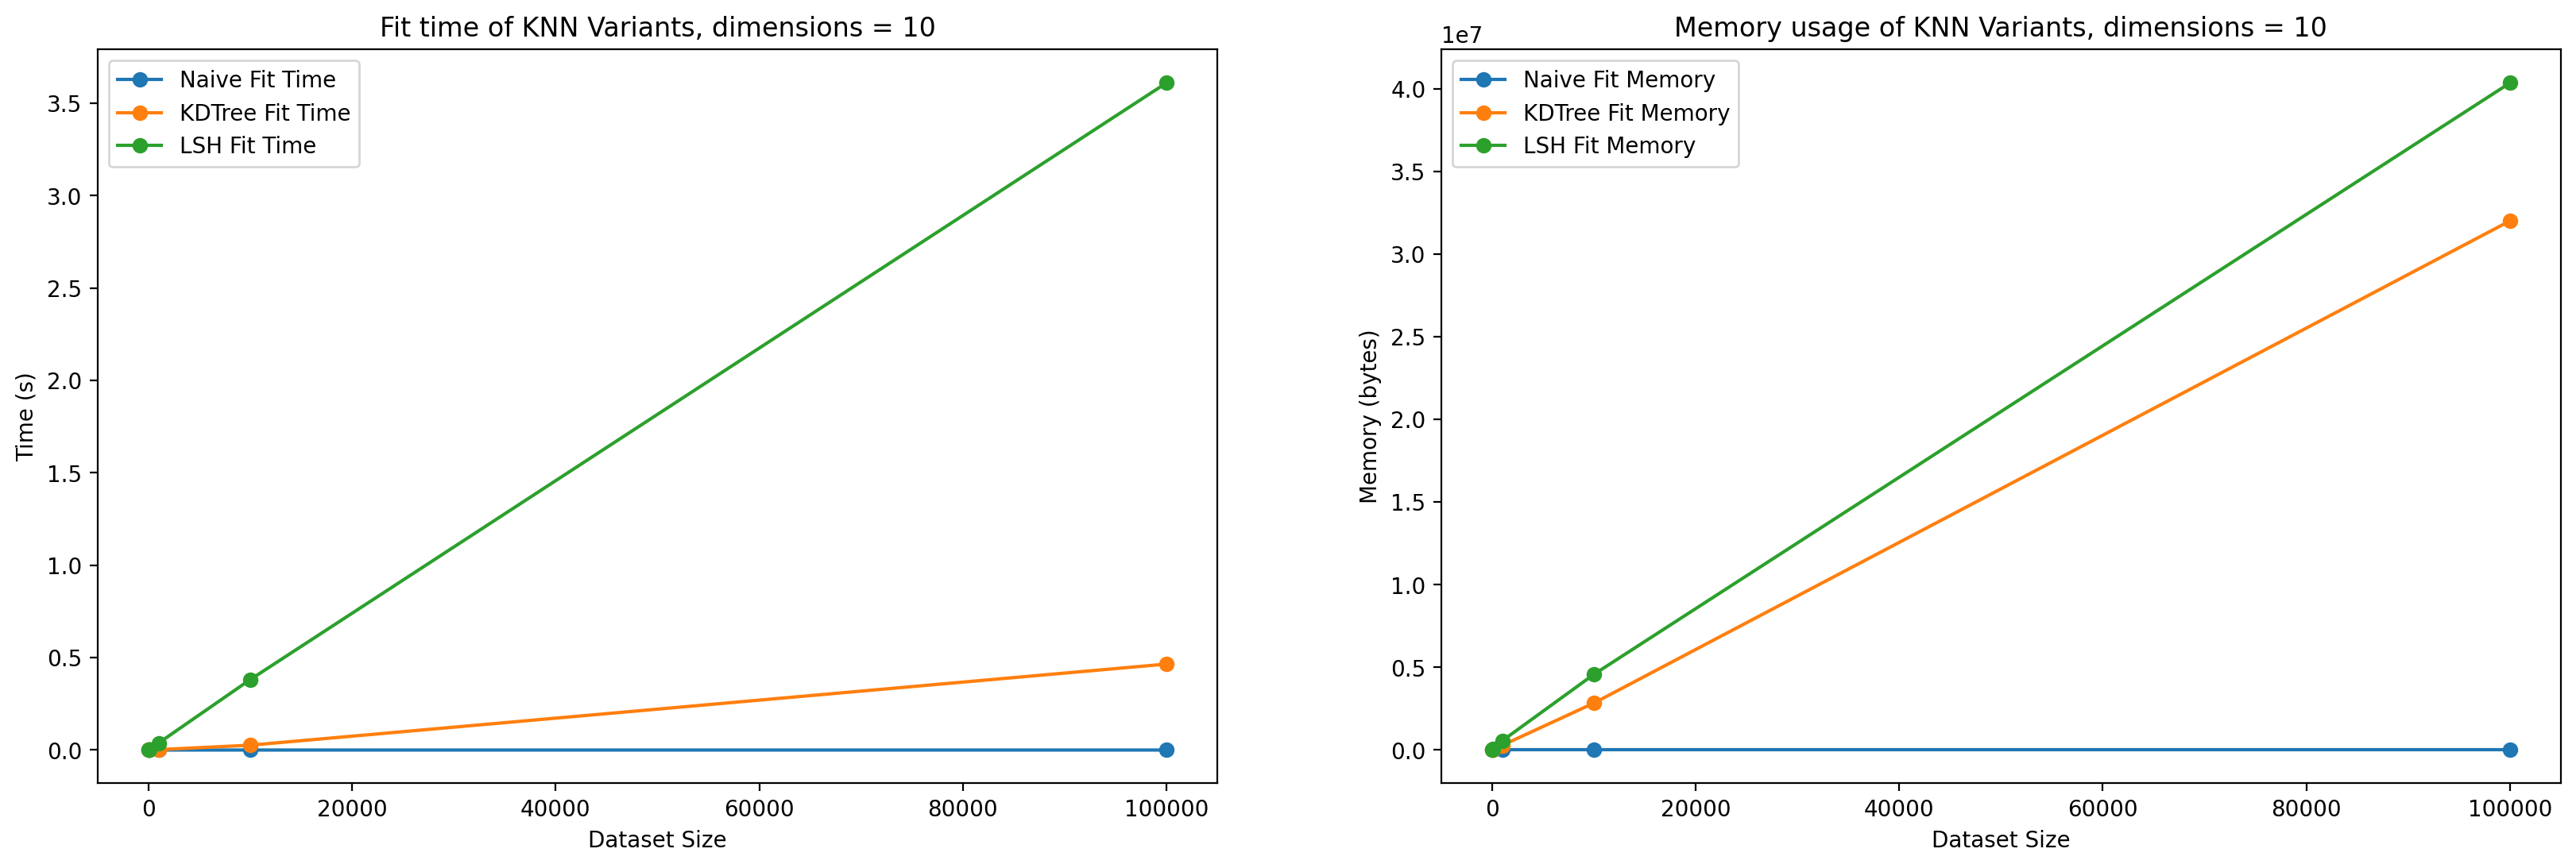

<Figure size 1000x600 with 0 Axes>

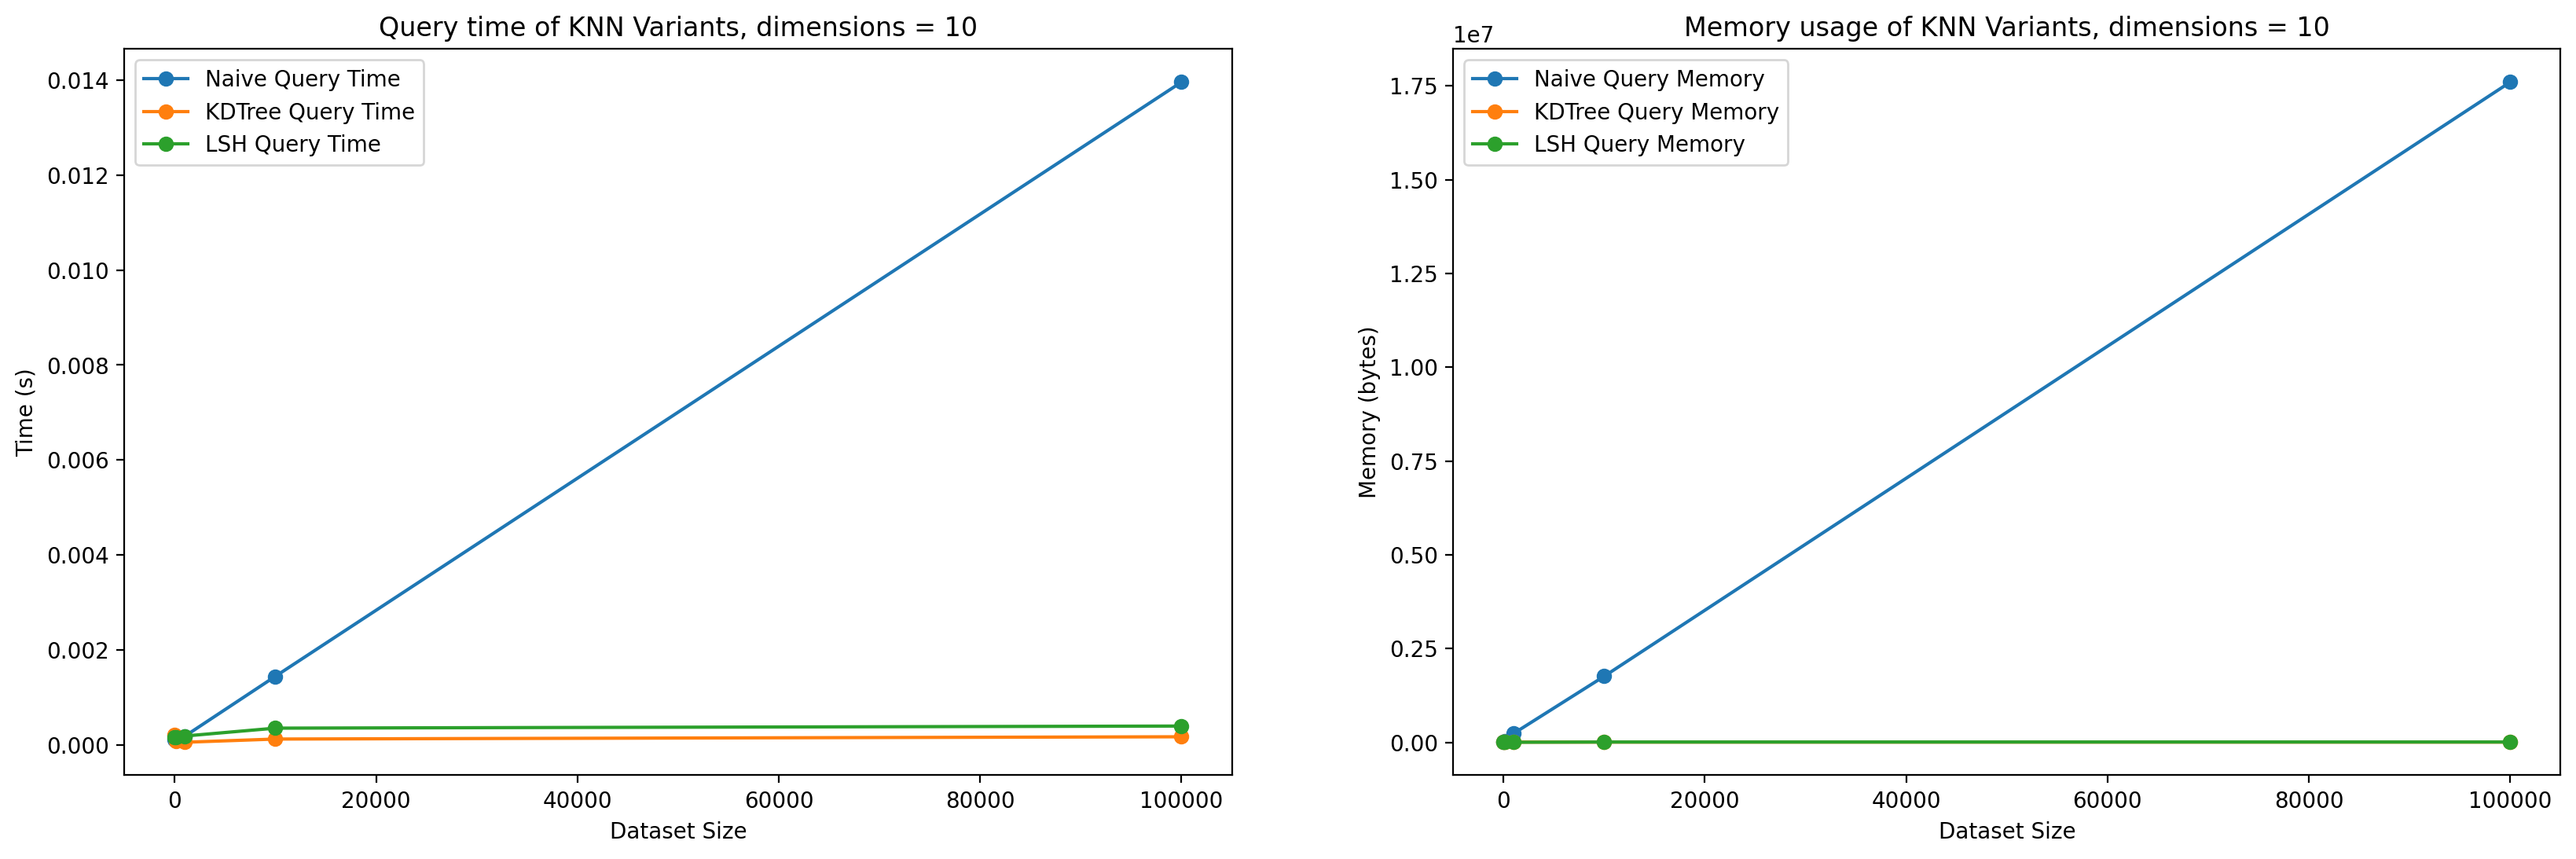

(101, 15) (100,)
(101, 15) (100,)
(101, 15) (100,)
(101, 15) (100,)
(101, 15) (100,)


<Figure size 1000x600 with 0 Axes>

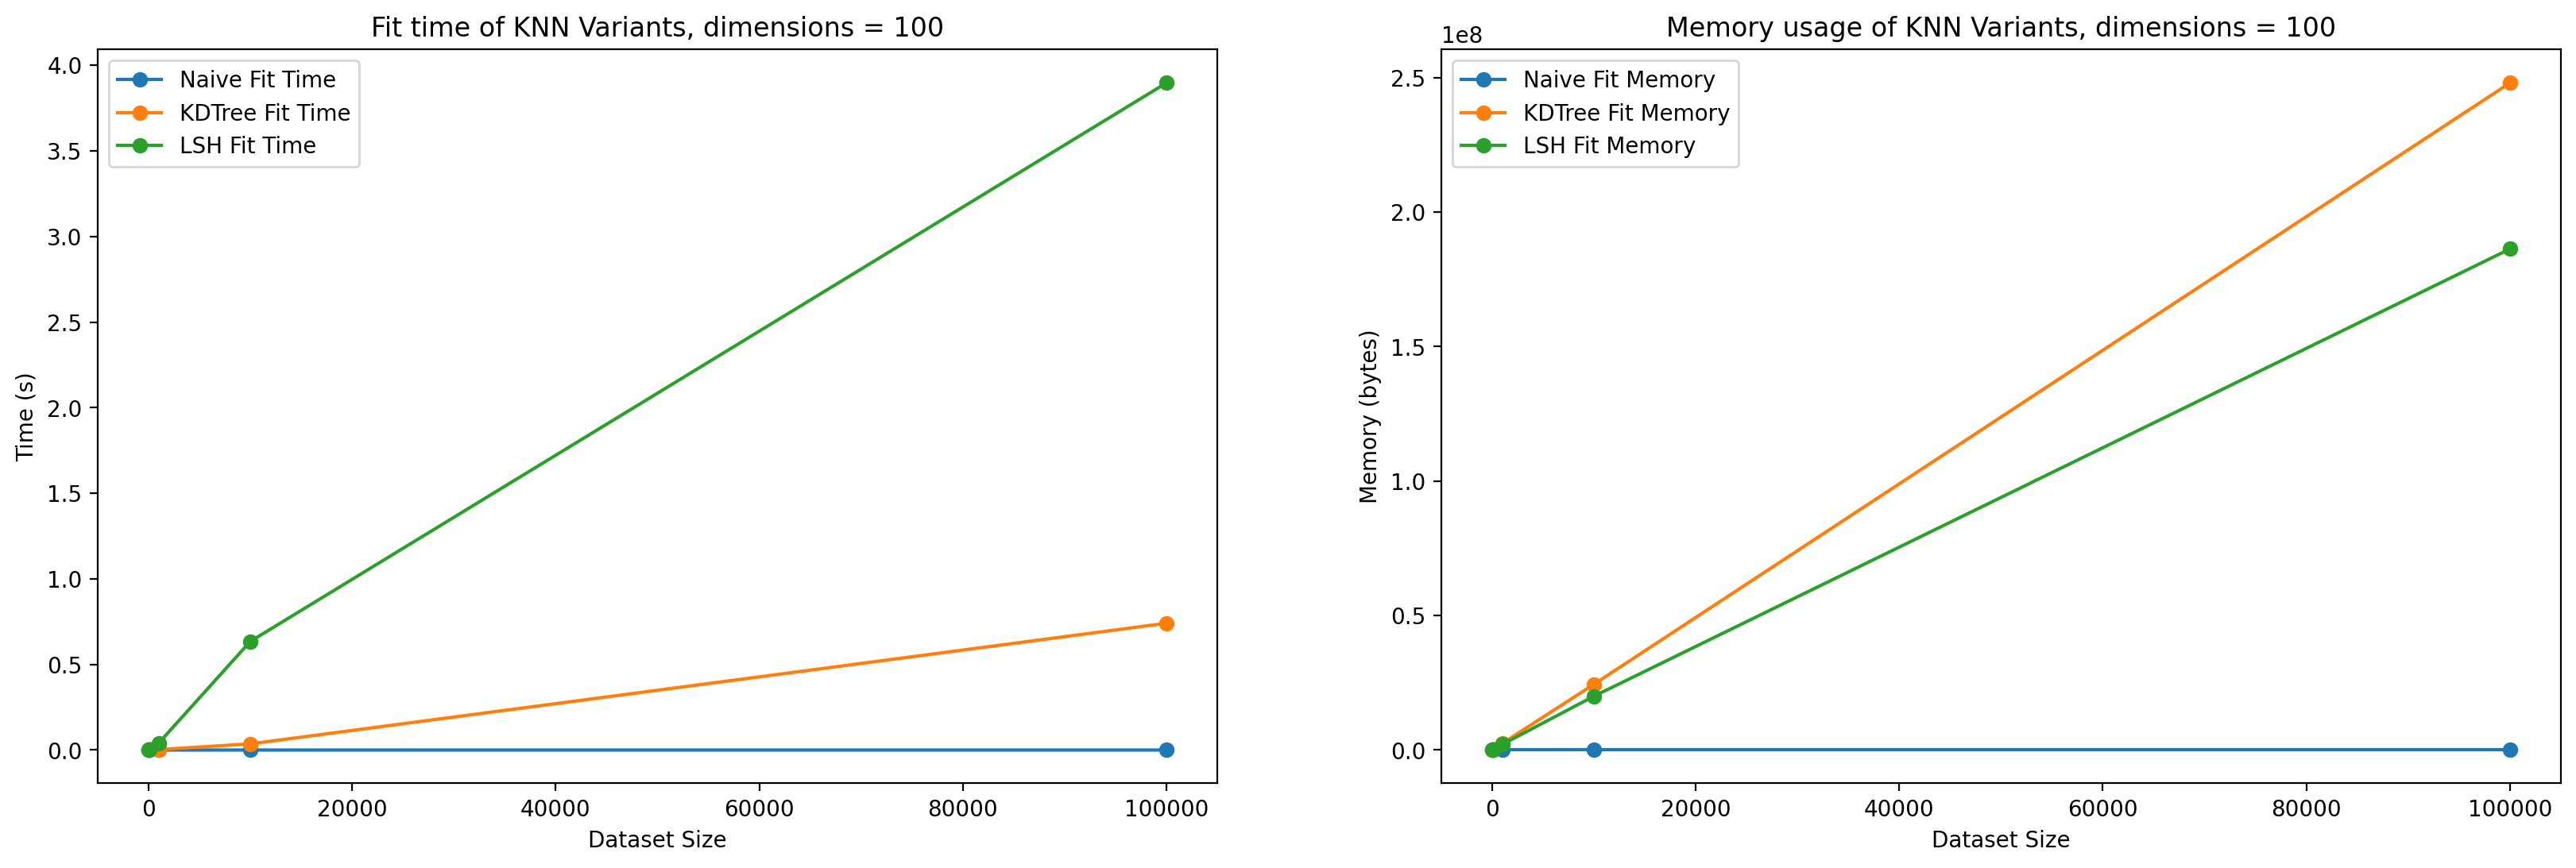

<Figure size 1000x600 with 0 Axes>

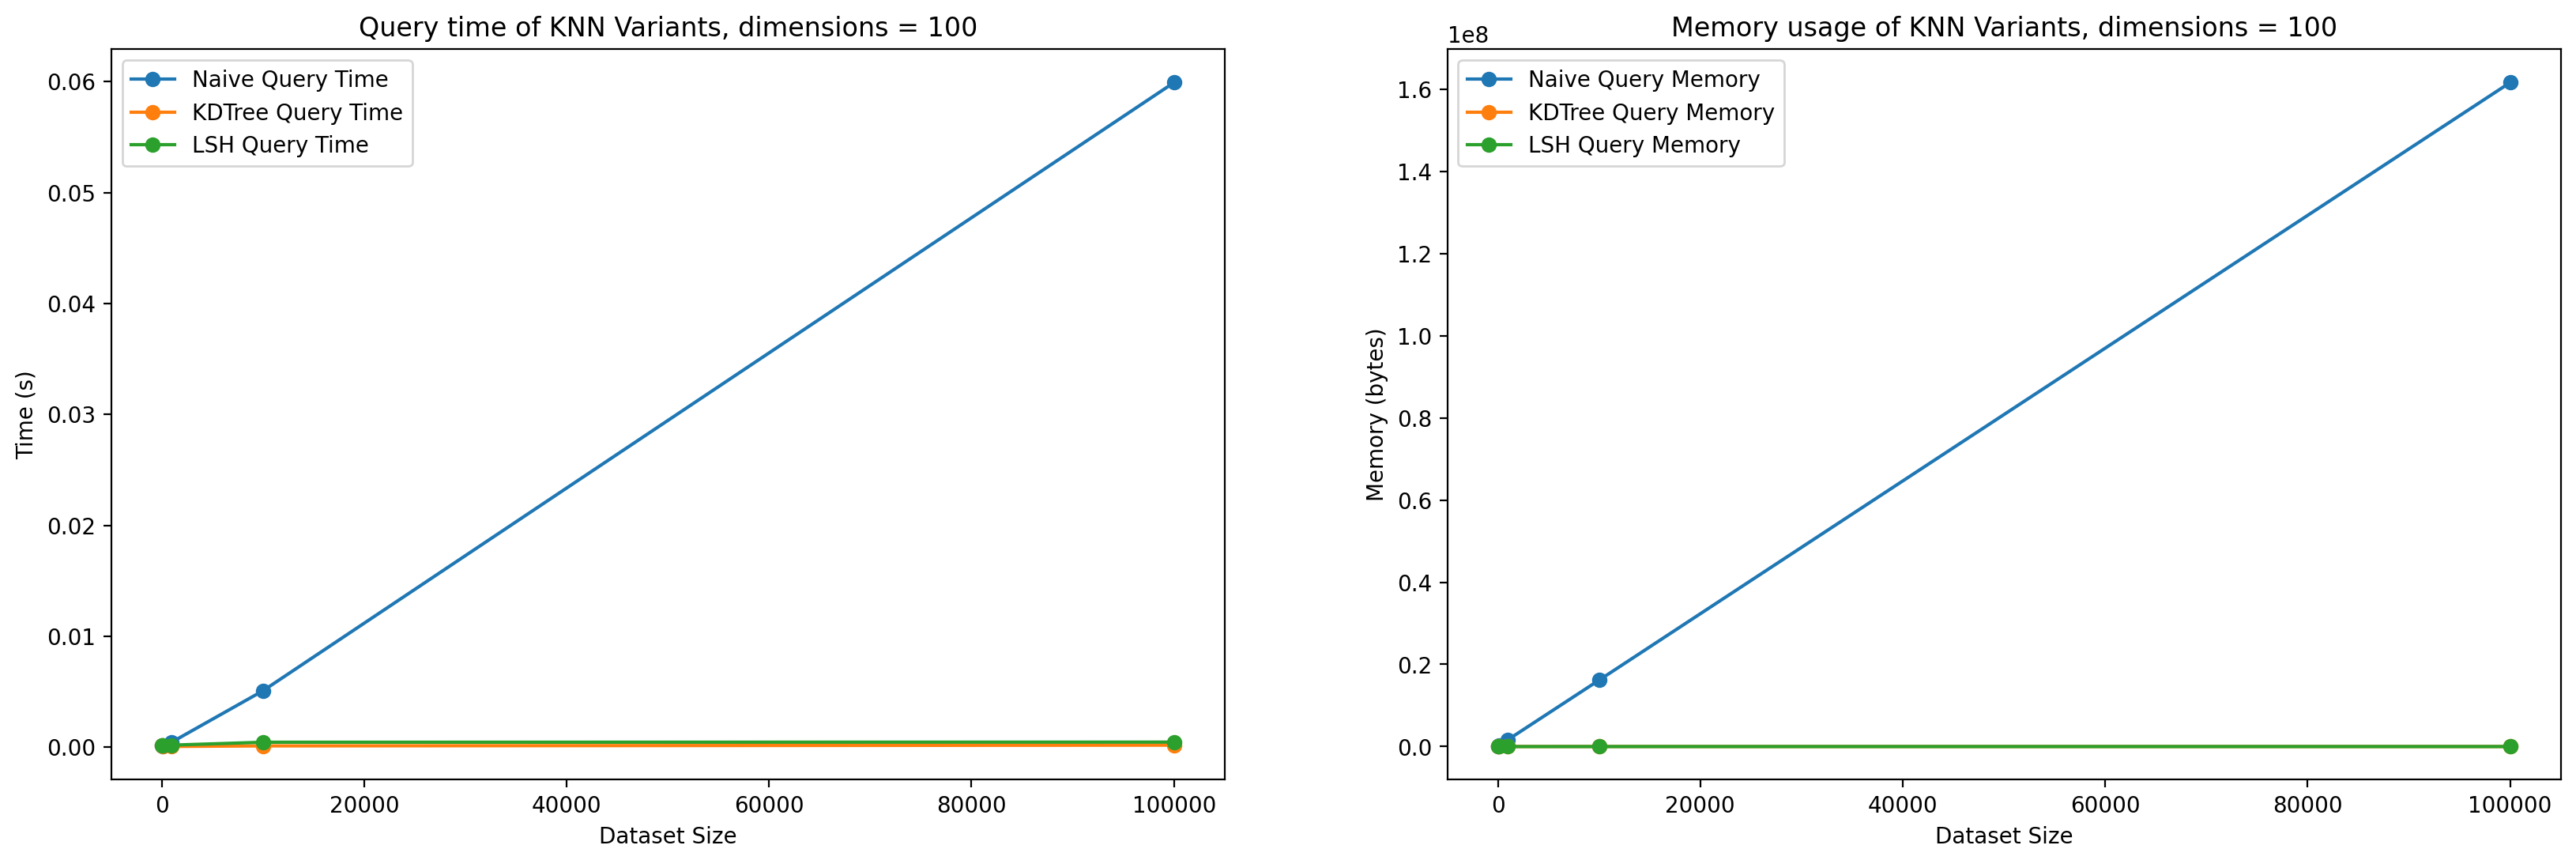

(1001, 15) (1000,)
(1001, 15) (1000,)
(1001, 15) (1000,)
(1001, 15) (1000,)
(1001, 15) (1000,)


<Figure size 1000x600 with 0 Axes>

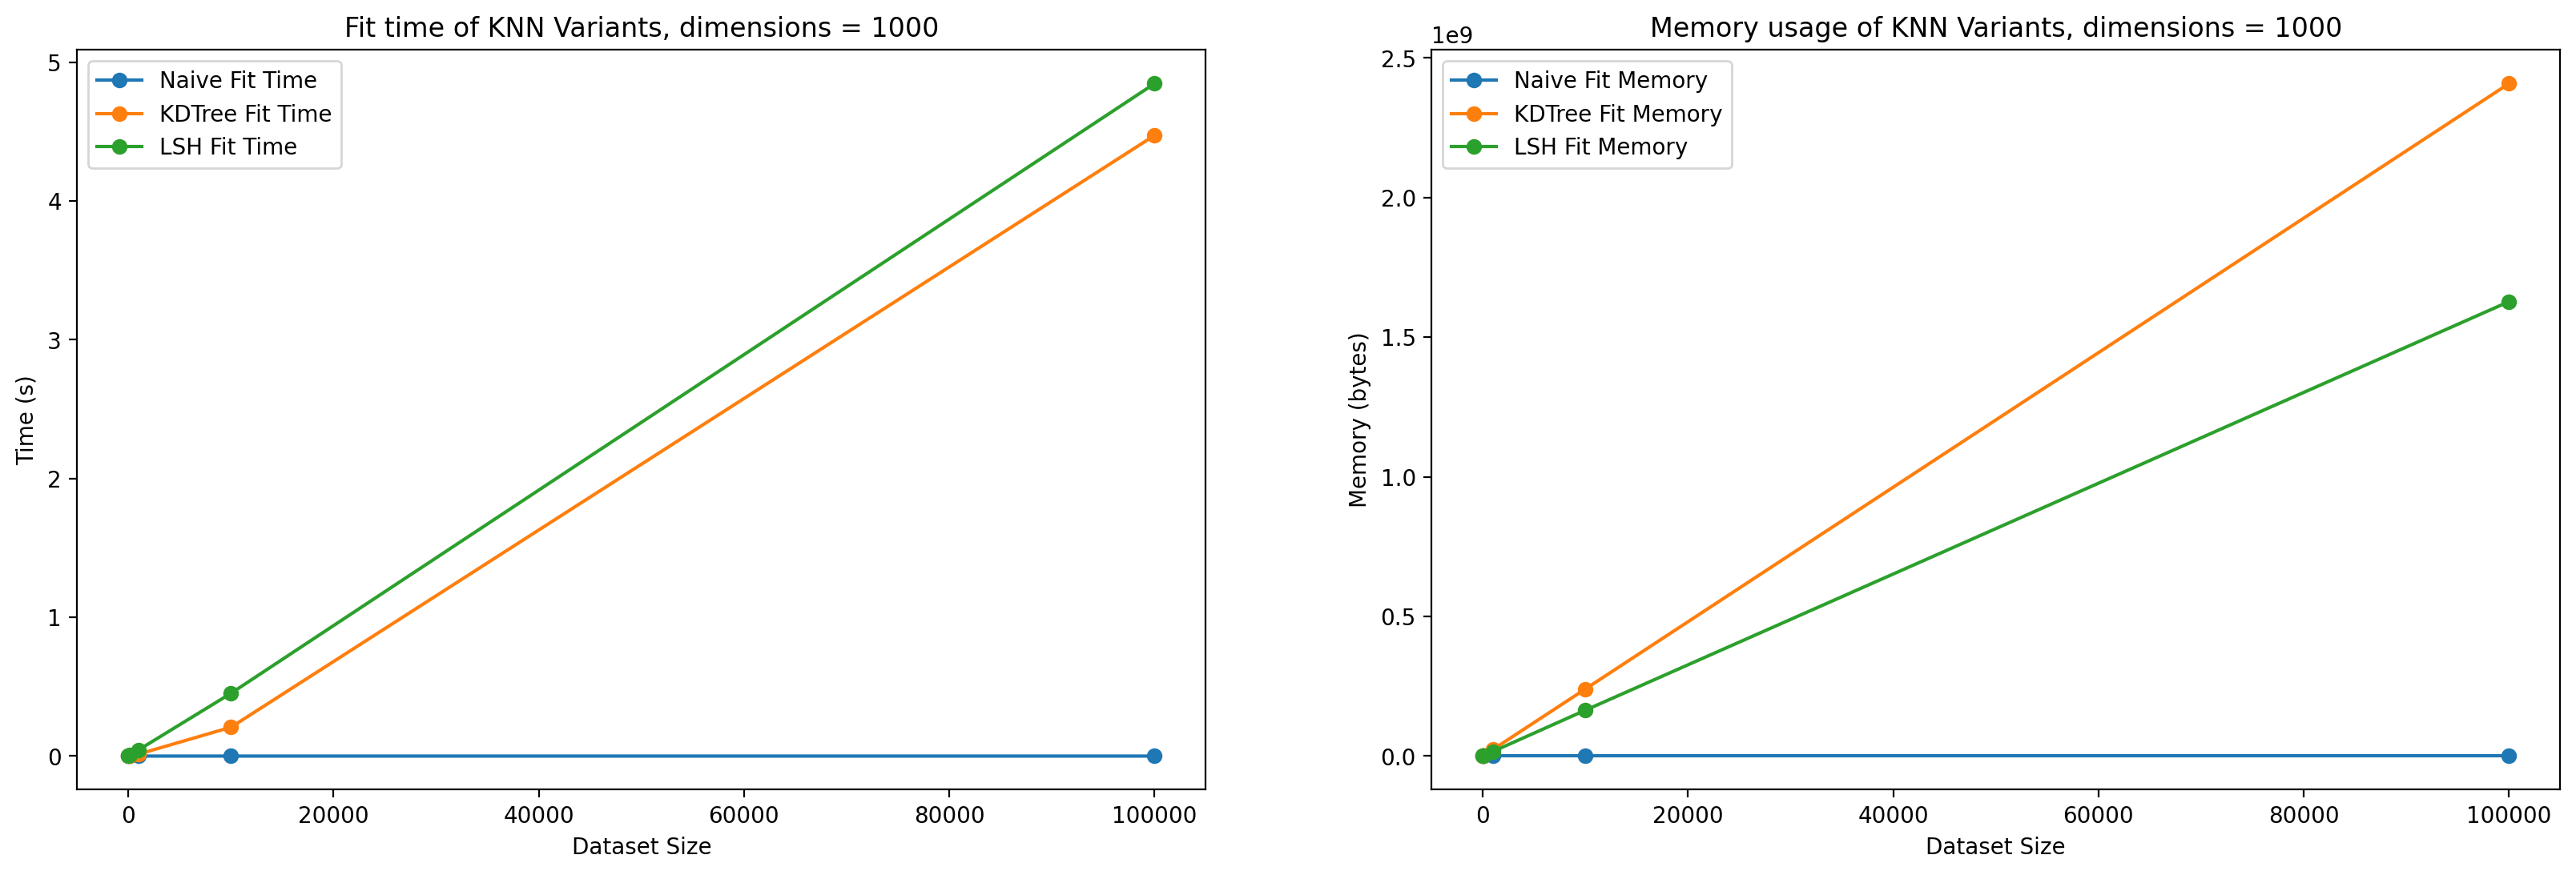

<Figure size 1000x600 with 0 Axes>

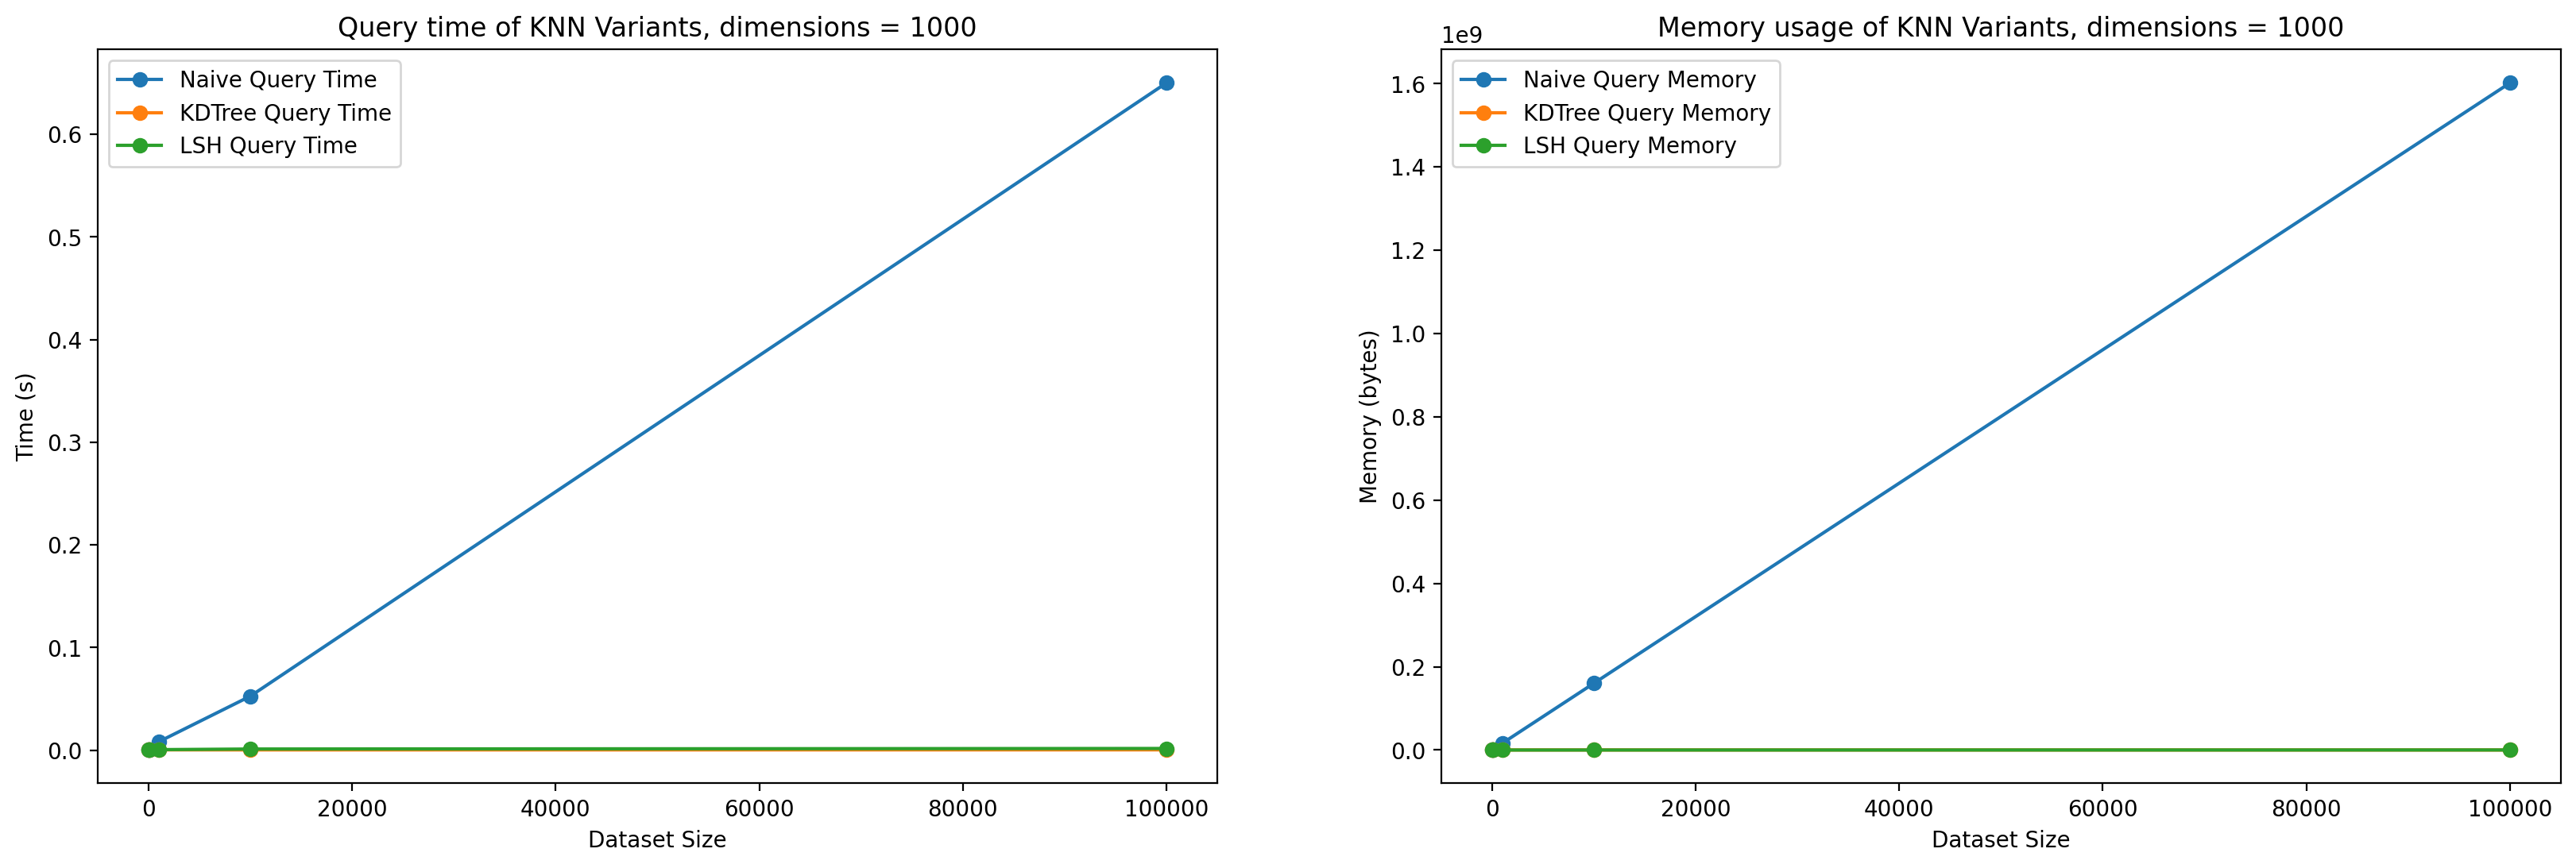

In [46]:
dataset_sizes = [10, 100, 1000, 10000, 100000]
dimensions = [2, 10, 100, 1000]


def benchmark_knn_all_plot(dimensions, dataset_sizes, n_neighbors=2, random_seed=42):      
    naive_times = []
    kdtree_times = []
    lsh_times = []
    for n in dataset_sizes:
            X = np.random.randn(n,dimensions)
            query_pt = np.random.randn(dimensions)
            naive_knn = NaiveKNN()
            kdtree = KDTree(min_samples_split=10)
            lsh = LSH(n_projections = 15, n_neighbors=2, radomn_seed=42)

            naive_time = benchmark_knn(naive_knn, X, query_pt, n_neighbors)
            kdtree_time = benchmark_knn(kdtree, X, query_pt, n_neighbors)
            lsh_time = benchmark_knn(lsh, X, query_pt, n_neighbors) 

            naive_times.append(naive_time)
            kdtree_times.append(kdtree_time)
            lsh_times.append(lsh_time)

    naive_times = np.array(naive_times)
    kdtree_times = np.array(kdtree_times)
    lsh_times = np.array(lsh_times)

    plt.figure(figsize=(10, 6))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.plot(dataset_sizes, naive_times[:, 0], label="Naive Fit Time", marker='o')
    ax1.plot(dataset_sizes, kdtree_times[:, 0], label="KDTree Fit Time", marker='o')
    ax1.plot(dataset_sizes, lsh_times[:, 0], label="LSH Fit Time", marker='o')
    ax1.set_xlabel("Dataset Size")
    ax1.set_ylabel("Time (s)")
    ax1.set_title(f"Fit time of KNN Variants, dimensions = {dimensions}")
    ax1.legend()

    ax2.plot(dataset_sizes, naive_times[:, 2], label="Naive Fit Memory", marker='o')
    ax2.plot(dataset_sizes, kdtree_times[:, 2], label="KDTree Fit Memory", marker='o')
    ax2.plot(dataset_sizes, lsh_times[:, 2], label="LSH Fit Memory", marker='o')
    ax2.set_xlabel("Dataset Size")
    ax2.set_ylabel("Memory (bytes)")
    ax2.set_title(f"Memory usage of KNN Variants, dimensions = {dimensions}")
    ax2.legend()

    plt.show()

    plt.figure(figsize=(10, 6))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    ax1.plot(dataset_sizes, naive_times[:, 1], label="Naive Query Time", marker='o')
    ax1.plot(dataset_sizes, kdtree_times[:, 1], label="KDTree Query Time", marker='o')
    ax1.plot(dataset_sizes, lsh_times[:, 1], label="LSH Query Time", marker='o')
    ax1.set_xlabel("Dataset Size")
    ax1.set_ylabel("Time (s)")
    ax1.set_title(f"Query time of KNN Variants, dimensions = {dimensions}")
    ax1.legend()

    ax2.plot(dataset_sizes, naive_times[:, 3], label="Naive Query Memory", marker='o')
    ax2.plot(dataset_sizes, kdtree_times[:, 3], label="KDTree Query Memory", marker='o')
    ax2.plot(dataset_sizes, lsh_times[:, 3], label="LSH Query Memory", marker='o')
    ax2.set_xlabel("Dataset Size")
    ax2.set_ylabel("Memory (bytes)")
    ax2.set_title(f"Memory usage of KNN Variants, dimensions = {dimensions}")
    ax2.legend()

    plt.show()
    

for i in dimensions:
    benchmark_knn_all_plot(i, dataset_sizes)

*Varying $K$ and testing* 

(501, 15) (500,)
(501, 15) (500,)
(501, 15) (500,)
(501, 15) (500,)
(501, 15) (500,)


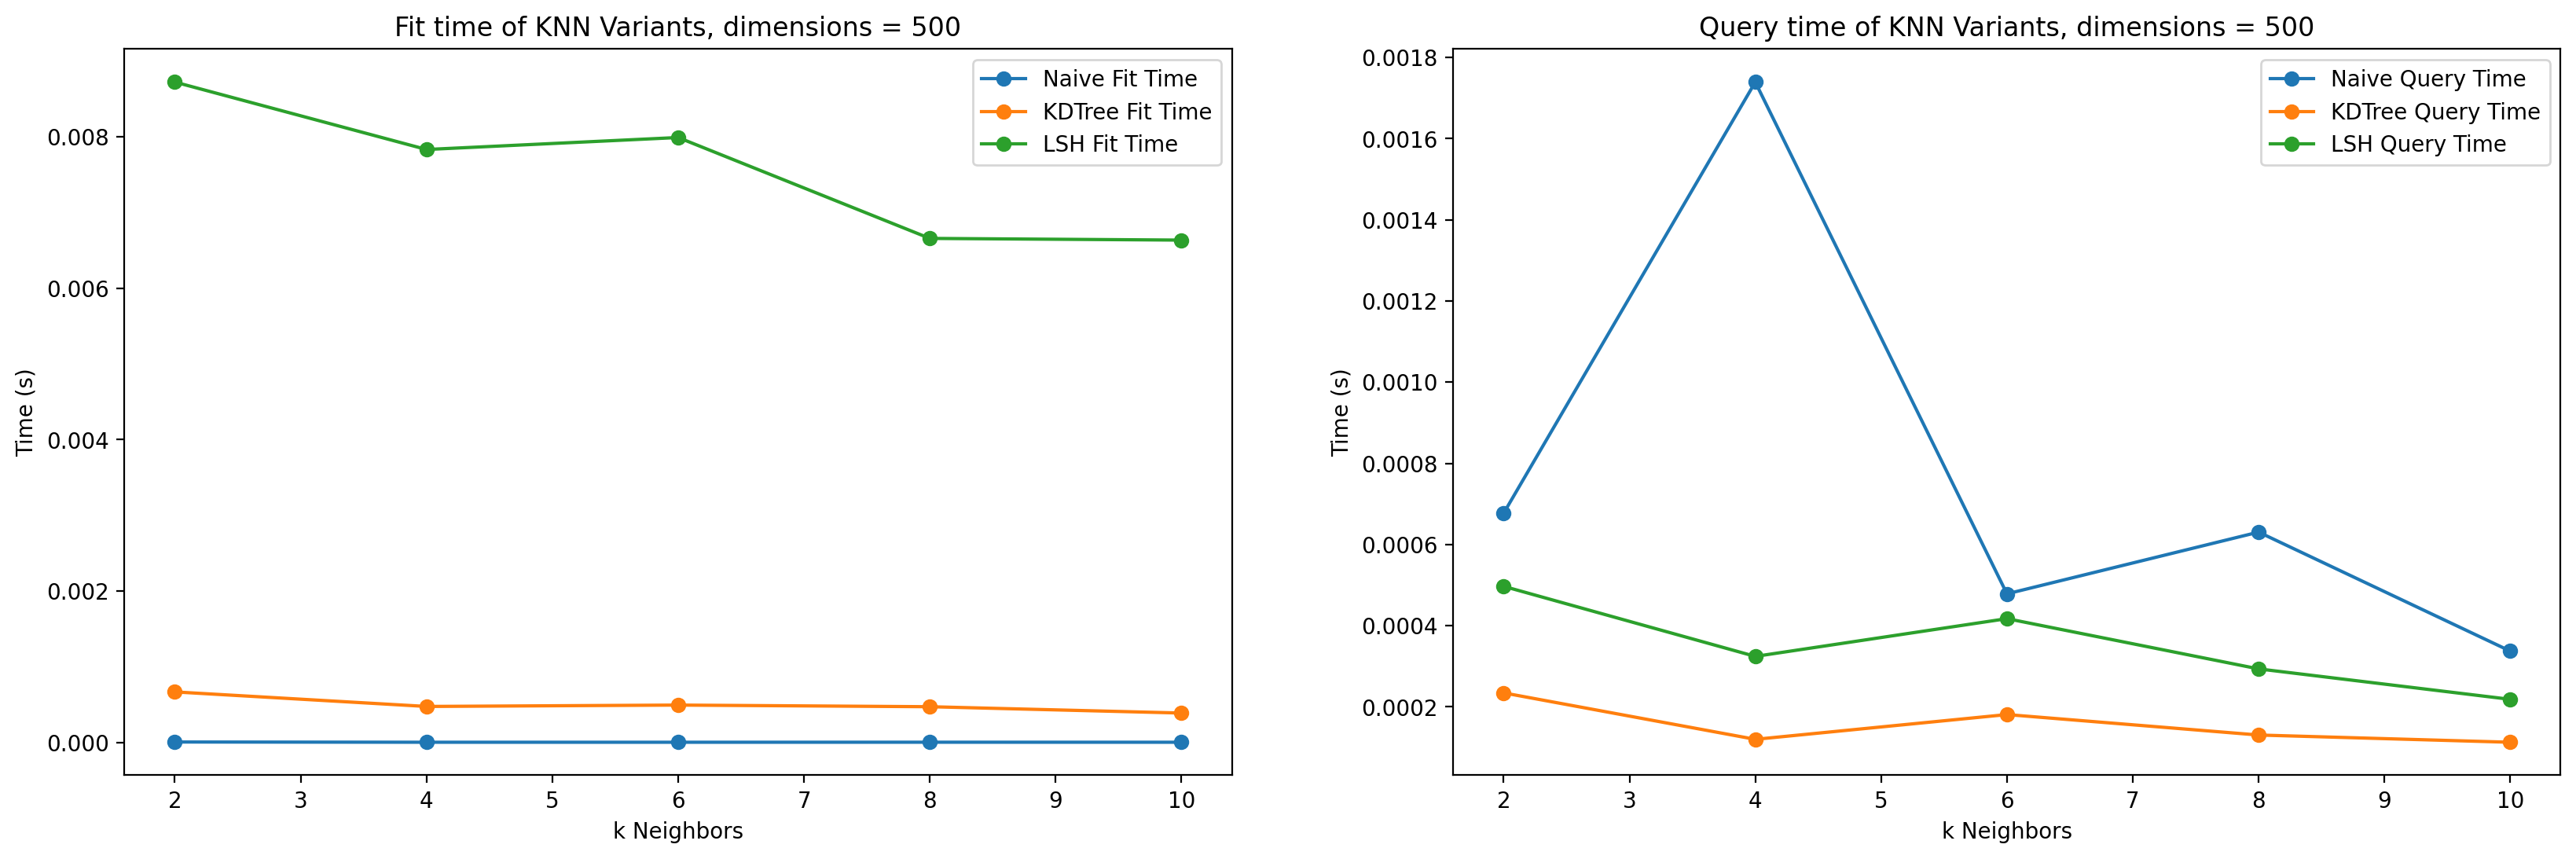

In [63]:
dataset_sizes = [10000]
dimensions = 500
vary_k = [2, 4, 6, 8, 10]

X = np.random.randn(n,dimensions)
query_pt = np.random.randn(dimensions)
naive_times = []
kdtree_times = []
lsh_times = []
for n_neighbors in vary_k:
    
    naive_knn = NaiveKNN()
    kdtree = KDTree(min_samples_split=15)
    lsh = LSH(n_projections = 15, n_neighbors=n_neighbors, radomn_seed=42)

    naive_time = benchmark_knn(naive_knn, X, query_pt, n_neighbors)
    kdtree_time = benchmark_knn(kdtree, X, query_pt, n_neighbors)
    lsh_time = benchmark_knn(lsh, X, query_pt, n_neighbors) 

    naive_times.append(naive_time)
    kdtree_times.append(kdtree_time)
    lsh_times.append(lsh_time)


naive_times = np.array(naive_times)
kdtree_times = np.array(kdtree_times)
lsh_times = np.array(lsh_times)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(vary_k, naive_times[:, 0], label="Naive Fit Time", marker='o')
ax1.plot(vary_k, kdtree_times[:, 0], label="KDTree Fit Time", marker='o')
ax1.plot(vary_k, lsh_times[:, 0], label="LSH Fit Time", marker='o')
ax1.set_xlabel("k Neighbors")
ax1.set_ylabel("Time (s)")
ax1.set_title(f"Fit time of KNN Variants, dimensions = {dimensions}")
ax1.legend()

ax2.plot(vary_k, naive_times[:, 1], label="Naive Query Time", marker='o')
ax2.plot(vary_k, kdtree_times[:, 1], label="KDTree Query Time", marker='o')
ax2.plot(vary_k, lsh_times[:, 1], label="LSH Query Time", marker='o')
ax2.set_xlabel("k Neighbors")
ax2.set_ylabel("Time (s)")
ax2.set_title(f"Query time of KNN Variants, dimensions = {dimensions}")
ax2.legend()

plt.show()